In [1]:
import os, glob
import numpy as np

from yellowbrick.target import FeatureCorrelation
from yellowbrick.features import Rank2D
from yellowbrick.features.pca import PCADecomposition

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import h5py
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from GNN.utils.datautils import get_data, balance_dataset, find_transition_regions

/cosma/local/Python/3.6.5/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
label = "dark_or_light"
sampling = "downsampling"

# 1. Load combined features from SubFind & Sownak 

In [3]:
# arxiv:1905.08799 talks about this stellar mass cut on page 4 top right column
output_file = 'merged_dataframe.h5'                                          
data_path = '/cosma6/data/dp004/dc-cues1/tng_dataframes/'

train, test = get_data(data_path + output_file, label)

In [4]:
train.sample(n=3, random_state=1)

,M200_DMO,M200c,Rmax,R200c,Cnfw,Rhosnfw,Formation Time,Nmergers,MassPeak,vpeak,N_subhalos,VelDisp,Vmax,Spin,fsub_unbound,x_offset,x_dmo,y_dmo,z_dmo,labels
33967,3.222000e+11,3.222035e+11,0.025756,111.500549,9.541781,1.095388e+07,1.151545,1.0,5.354194e+11,158.870071,1.0,73.738907,132.469254,13.077200,0.007121,657.466485,265.680687,269.871812,199.033187,True
87515,1.594000e+11,1.594472e+11,0.015614,88.186943,16.635263,4.515792e+07,1.966384,1.0,2.638693e+11,116.536285,2.0,62.604664,114.830658,5.033566,0.008136,2196.179003,144.617547,260.009687,162.087938,True
14264,4.474000e+11,4.473788e+11,0.058838,124.389297,4.836464,2.172080e+06,1.044931,2.0,7.858822e+11,138.228745,9.0,74.484482,128.212570,10.046845,0.170153,1174.137065,42.755012,50.261793,204.619156,True


In [5]:
## Balance training set in the transition region                             
center_transition, end_transition = find_transition_regions(train)

/cosma/home/dp004/dc-beck3/.local/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


In [13]:
# TODO: doesn't work yet
"""
train = balance_dataset(                                                     
    train, center_transition, end_transition, sampling
)
"""

'\ntrain = balance_dataset(                                                     \n    train, center_transition, end_transition, sampling\n)\n'

In [14]:
train_features = train.drop(columns="labels")                                
train_labels = train["labels"]

test_features = test.drop(columns="labels")                                
test_labels = test["labels"]

In [15]:
train_features.columns

Index(['M200_DMO', 'M200c', 'Rmax', 'R200c', 'Cnfw', 'Rhosnfw',
       'Formation Time', 'Nmergers', 'MassPeak', 'vpeak', 'N_subhalos',
       'VelDisp', 'Vmax', 'Spin', 'fsub_unbound', 'x_offset', 'x_dmo', 'y_dmo',
       'z_dmo'],
      dtype='object')

# 2 Feature Importance

## 2.1 Pearson correlation score

/cosma/home/dp004/dc-beck3/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


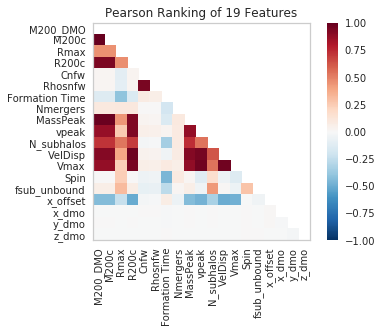

In [16]:
visualizer = Rank2D(features=train_features.columns.values, algorithm='pearson')

visualizer.fit(train_features.values, test_labels.values)
visualizer.transform(train_features)  
visualizer.poof()  

In [18]:
pca = PCA(n_components=len(train_features.columns.values))
train_feat_pca = pca.fit_transform(train_features.values)

In [21]:
train_feat_pca.shape[0]

69842

In [29]:
train_feat_pca_df = pd.DataFrame(
    data=train_feat_pca,
    index=np.arange(train_feat_pca.shape[0]),
    columns=['PCA_%d' % dd for dd in range(train_feat_pca.shape[1])],
)

train_feat_pca_df.sample(n=3, random_state=1)

/cosma/home/dp004/dc-beck3/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


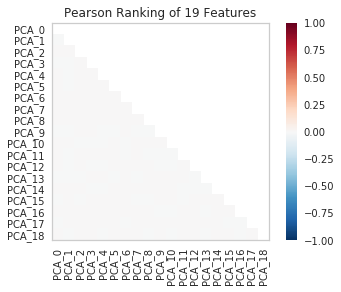

In [31]:
visualizer = Rank2D(features=train_feat_pca_df.columns.values, algorithm='pearson')

visualizer.fit(train_feat_pca_df.values, test_labels.values)
visualizer.transform(train_feat_pca_df)  
visualizer.poof()

## 2.2 PCA - variance ratios in scaled dataset

In [ ]:
scaler = StandardScaler()

scaler_data = scaler.fit_transform(df_subf)
pca = PCA().fit(scaler_data)

# Plot
fig, ax1 = plt.subplots()

# Axis 1
ax1.semilogy(
    pca.explained_variance_ratio_,
    '--bo',
    label='explained variance ratio',
)
color =  ax1.lines[0].get_color()
for tl in ax1.get_yticklabels():
    tl.set_color('b')
ax1.set_xlabel('principal component')
plt.legend(loc=(0.01, 0.075))

# Axis 2
ax2 = ax1.twinx()
ax2.semilogy(
    pca.explained_variance_ratio_.cumsum(),
    '--go',
    label='cumulative explained variance ratio',
)
for tl in ax2.get_yticklabels():
    tl.set_color('g')

plt.legend(loc=(0.01, 0))

## 2.3 PCA - inverse & biases

In [ ]:
n_comp = 7
pca = PCA(n_components=n_comp)

data_scaled = StandardScaler().fit_transform(df_subf)


pca_data = pca.fit_transform(data_scaled)
pca_inv_data = pca.inverse_transform(np.eye(n_comp))

In [ ]:
# Inverse

sns.heatmap(
    #np.log(pca_inv_data),
    pca.inverse_transform(np.eye(n_comp)),
    cmap="hot",
    cbar=False,
)
plt.xlabel('original feature index')
plt.ylabel('principal component')

In [ ]:
# Biases

plt.plot(
    pca_inv_data.mean(axis=0), 
    '--o',
    label='mean',
)
plt.plot(
    np.square(pca_inv_data.std(axis=0)),
    '--o',
    label='variance',
)
plt.legend(loc='best')
plt.ylabel('feature contribution')
plt.xlabel('feature index')